In [9]:
from sklearn.metrics import precision_recall_fscore_support
from difflib import SequenceMatcher
from scripts.config import DefaultArgsNamespace
import pandas as pd
import numpy as np
import os
import seaborn as sns
from sklearn.metrics import average_precision_score, precision_recall_curve
import editdistance

args = DefaultArgsNamespace()

In [10]:
results_csv = './results/model_id_65302224_on_20241025-112558/preds.csv'

task = args.dataloader_params['task']
print("Task is", task)

Task is segmentation


In [11]:
# get keysteps dict
keysteps_dict = args.dataloader_params['keysteps']
# Inverting the dictionary to map keystep_id to natural language description
keystep_id_to_desc = {i: v for i, v in enumerate(keysteps_dict.values())}

keysteps_dict = keystep_id_to_desc


# Preprocessing

In [12]:
# Read CSV
df = pd.read_csv(results_csv)

unique_actions = np.union1d(np.concatenate(df['keystep_id'].apply(eval).values), df['pred_keystep_id'].values)

# Lists to hold ground truth and predicted sequences for all trials
all_ground_truth = []
all_predicted = []

# Convert the lists in subject_id and trial_id columns to single values
df['subject_id'] = df['subject_id'].apply(lambda x: eval(x)[0] if isinstance(x, str) else x)
df['trial_id'] = df['trial_id'].apply(lambda x: eval(x)[0] if isinstance(x, str) else x)

# Show the updated dataframe
df.head()

# Convert string arrays to actual lists for all relevant columns
def convert_to_list(value):
    try:
        return eval(value) if isinstance(value, str) else value
    except:
        return value  # If eval fails, return the original value

# Apply the conversion to the columns that contain arrays as strings
columns_to_convert = ['keystep_label', 'keystep_id', 'start_frame', 'end_frame', 'start_t', 'end_t', 'all_preds']  # Add any other columns if needed

for column in columns_to_convert:
    df[column] = df[column].apply(convert_to_list)

# Show the first few rows to verify the conversion
df.head()

# Function to convert string arrays and extract the inner array
def extract_inner_array(value):
    try:
        # Convert the string to a Python list
        converted_value = eval(value) if isinstance(value, str) else value
        # If it's a list of lists, return the first list (the inner array)
        if isinstance(converted_value, list) and len(converted_value) > 0 and isinstance(converted_value[0], list):
            return converted_value[0]
        return converted_value
    except:
        return value  # If eval fails, return the original value

# Apply the conversion to the columns that contain arrays as strings
columns_to_convert = ['keystep_label', 'keystep_id', 'start_frame', 'end_frame', 'start_t', 'end_t', 'all_preds']  # Add any other columns if needed

for column in columns_to_convert:
    df[column] = df[column].apply(extract_inner_array)

# Show the first few rows to verify the conversion
df.head()


,keystep_label,keystep_id,start_frame,end_frame,start_t,end_t,window_start_frame,window_end_frame,subject_id,trial_id,pred_keystep_id,all_preds
0,"[approach_patient, approach_patient, approach_...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[198, 198, 198, 198, 198, 198, 198, 198, 198, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[6.608630180358887, 6.608630180358887, 6.60863...",0,120,ms1,0,0,"[5.73012638092041, 0.445463091135025, 0.365629..."
1,"[approach_patient, approach_patient, approach_...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[198, 198, 198, 198, 198, 198, 198, 198, 198, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[6.608630180358887, 6.608630180358887, 6.60863...",120,240,ms1,0,0,"[5.831171035766602, 3.5325310230255127, 2.8858..."
2,"[check_responsiveness, check_responsiveness, c...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[198, 198, 198, 198, 198, 198, 198, 198, 198, ...","[342, 342, 342, 342, 342, 342, 342, 342, 342, ...","[6.609000205993652, 6.609000205993652, 6.60900...","[11.418919563293457, 11.418919563293457, 11.41...",240,360,ms1,0,15,"[1.7756500244140625, 3.1439244747161865, 3.367..."
3,"[check_pulse, check_pulse, check_pulse, check_...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[342, 342, 342, 342, 342, 342, 342, 342, 342, ...","[401, 401, 401, 401, 401, 401, 401, 401, 401, ...","[11.418999671936035, 11.418999671936035, 11.41...","[13.395000457763672, 13.395000457763672, 13.39...",360,480,ms1,0,2,"[-0.43847012519836426, 3.0513341426849365, 4.0..."
4,"[chest_compressions, chest_compressions, chest...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[472, 472, 472, 472, 472, 472, 472, 472, 472, ...","[584, 584, 584, 584, 584, 584, 584, 584, 584, ...","[15.77299976348877, 15.77299976348877, 15.7729...","[19.509029388427734, 19.509029388427734, 19.50...",480,600,ms1,0,4,"[0.7568711042404175, -0.2066485583782196, -0.3..."


In [13]:
from sklearn.metrics import average_precision_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np
from difflib import SequenceMatcher

# Function to calculate edit score
def calculate_edit_score(ground_truth, predicted, edit_distance):
    max_len = max(len(ground_truth), len(predicted))
    if max_len == 0:  # To avoid division by zero
        return 1.0
    edit_score = 1 - (edit_distance / max_len)
    return np.round(edit_score, 4)

# Function to calculate Levenshtein distance (edit distance)
def calculate_edit_distance(ground_truth, predicted):
    edit_distance = editdistance.eval(ground_truth, predicted)
    return edit_distance


# Function to calculate AP for each action (keystep) and mAP
def calculate_ap_mAP(ground_truth, predicted, actions):
    aps = []
    for action in actions:
        # Convert the sequences into binary labels for each action
        true_binary = (np.array(ground_truth) == action).astype(int)
        pred_binary = (np.array(predicted) == action).astype(int)

        # Calculate Average Precision (AP)
        if np.sum(true_binary) > 0:  # Avoid calculating AP when no ground truth for action
            ap = average_precision_score(true_binary, pred_binary)
            aps.append(ap)
        else:
            aps.append(0.0)  # If no ground truth for this action, AP = 0

    # Calculate mean AP (mAP)
    mAP = np.mean(aps)
    return aps, mAP

# Function to calculate final average class-wise accuracy
def calculate_final_classwise_accuracy(all_ground_truth, all_predicted, actions):
    correct_predictions_per_class = {action: 0 for action in actions}
    total_samples_per_class = {action: 0 for action in actions}

    for ground_truth, predicted in zip(all_ground_truth, all_predicted):
        for action in actions:
            true_binary = np.array(ground_truth) == action
            pred_binary = np.array(predicted) == action
            
            correct_predictions = np.sum(true_binary & pred_binary)
            total_samples = np.sum(true_binary)

            correct_predictions_per_class[action] += correct_predictions
            total_samples_per_class[action] += total_samples

    # Calculate accuracy for each class
    classwise_accuracy = {}
    for action in actions:
        total_samples = total_samples_per_class[action]
        if total_samples > 0:
            classwise_accuracy[action] = np.round(correct_predictions_per_class[action] / total_samples, 4)
        else:
            classwise_accuracy[action] = 0.0  # If no samples for this class

    return classwise_accuracy

# Function to calculate IoU (Intersection over Union)
def calculate_iou(pred_interval, gt_intervals):

    intersection = np.minimum(pred_interval[1],gt_intervals[:,1]) - np.maximum(pred_interval[0],gt_intervals[:,0])
    union = np.maximum(pred_interval[1],gt_intervals[:,1]) - np.minimum(pred_interval[0],gt_intervals[:,0])
    return (intersection / union)

def calculate_f1_at_k(ground_truth, prediction, k, n_classes=3):

    # Break the ground truth and prediction into segments with start and end indices
    gt_intervals = []
    pred_intervals = []
    
    gt_labels = []
    pred_labels = []
    # Find start and end of each ground truth segment
    start_idx = 1
    for i in range(1, len(ground_truth)):
        if ground_truth[i] != ground_truth[i - 1]:
            gt_intervals.append((start_idx, i ))
            gt_labels.append(ground_truth[i-1])
            start_idx = i+1
    # Append the last ground truth segment
    gt_intervals.append((start_idx, len(ground_truth)))
    gt_labels.append(ground_truth[-1])

    # Find start and end of each prediction segment
    start_idx = 1
    for i in range(1, len(prediction)):
        if prediction[i] != prediction[i - 1]:
            pred_intervals.append((start_idx, i))
            pred_labels.append(prediction[i-1])
            start_idx = i+1
    # Append the last prediction segment
    pred_intervals.append((start_idx, len(prediction)))
    pred_labels.append(prediction[-1])

    gt_intervals = np.array(gt_intervals)
    pred_intervals = np.array(pred_intervals)

        # We keep track of the per-class TPs, and FPs.
    # In the end we just sum over them though.
    TP = np.zeros(n_classes+1, float)
    FP = np.zeros(n_classes+1, float)


    n_pred = len(pred_intervals)
    n_true = len(gt_intervals)

    true_used = np.zeros(n_true, float)

    for i in range(n_pred):
        current_pred_interval = pred_intervals[i]
        current_pred_label = pred_labels[i]

        IoU = calculate_iou(current_pred_interval, gt_intervals)*(np.array(gt_labels) == current_pred_label)

        idx = np.argmax(IoU)

        # If the IoU is high enough and the true segment isn't already used
        # Then it is a true positive. Otherwise is it a false positive.
        if IoU[idx] >= k and not true_used[idx]:
            TP[pred_labels[i]] += 1
            true_used[idx] = 1
        else:
            FP[pred_labels[i]] += 1


    TP = TP.sum()
    FP = FP.sum()
    # False negatives are any unused true segment (i.e. "miss")
    FN = n_true - true_used.sum()
    
    precision = TP / (TP+FP)
    recall = TP / (TP+FN)
    F1 = 2 * (precision*recall) / (precision+recall)

    # If the prec+recall=0, it is a NaN. Set these to 0.
    F1 = np.nan_to_num(F1)

    return F1, precision, recall, TP, FP, FN

# Example usage
# prediction =  [1, 1, 2, 2, 3, 3, 3]
# ground_truth =[1, 1, 1, 2, 2, 3, 3]
# k = 0.2  # IoU threshold (50%)

# print("prediction: ", prediction)
# print("ground_truth: ", ground_truth)

# f1_score, TP, FP, FN = calculate_f1_at_k(ground_truth, prediction, k)
# print(f"F1@{k}: {f1_score}")
# print(f"True Positives: {TP}, False Positives: {FP}, False Negatives: {FN}")





# Calculate Results

In [34]:
# Grouping by subject_id and trial_id
results = []

# Assuming 'results_csv' is defined earlier and points to the path of the results CSV
results_dir = results_csv.rsplit('/', 1)[0]

# IoU thresholds
IoU_thresholds = [0.1, 0.25, 0.5]

all_accuracy = []
all_edit_distances = []
all_edit_scores = []
all_precisions = {threshold: [] for threshold in IoU_thresholds}
all_recalls = {threshold: [] for threshold in IoU_thresholds}
all_f1_k = {threshold: [] for threshold in IoU_thresholds}

updated_df = []

for (subject, trial), group in df.groupby(['subject_id', 'trial_id']):
    print("*" * 50)
    print(f"Subject: {subject}, Trial: {trial}")
    
    # Extract ground truth and predicted keysteps
    ground_truth = group['keystep_id'].tolist()  # Ground truth per frame
    predicted = group['pred_keystep_id'].tolist()  # Predicted per frame
    
    def repeat_elements(arr, Y):
        # Use list comprehension to repeat each element Y times
        return [[element] * Y for element in arr]

    Y = len(ground_truth[0])  # For example, repeat each element 3 times
    new_array = repeat_elements(predicted, Y)
    predicted = new_array

    # make predicte

    group['predictions'] = predicted
    updated_df.append(group)
    edit_distances_for_trial = []
    edit_scores_for_trial = []

    # Calculate edit distance and edit score for each window and average
    for gt, pred in zip(ground_truth, predicted):
        edit_distance = calculate_edit_distance(ground_truth=gt, predicted=pred)
        edit_score = calculate_edit_score(gt, pred, edit_distance)

        edit_distances_for_trial.append(edit_distance)
        edit_scores_for_trial.append(edit_score)

    # Calculate average edit distance and edit score for the trial
    edit_distance = int(np.mean(edit_distances_for_trial))
    edit_score = np.mean(edit_scores_for_trial)

    all_edit_distances.append(edit_distance)
    all_edit_scores.append(edit_score)

    print("edit_distance: ", edit_distance)
    print("edit_score: ", edit_score)

    # Flatten ground truth and predicted sublists
    ground_truth = [item for sublist in ground_truth for item in sublist]
    predicted = [item for sublist in predicted for item in sublist]

    all_ground_truth.append(ground_truth)
    all_predicted.append(predicted)

    f1_aggregated_metrics = {}

    for threshold in IoU_thresholds:
        f1_score, precision, recall, TP, FP, FN = calculate_f1_at_k(ground_truth, predicted, threshold, n_classes=len(unique_actions))
        # Store precision, recall, f1 metrics for each threshold
        metrics = {
            f'precision@{threshold}': precision,
            f'recall@{threshold}': recall,
            f'f1@{threshold}': f1_score,
        }
        # Append precision, recall, and f1 to the respective lists
        all_precisions[threshold].append(precision)
        all_recalls[threshold].append(recall)
        all_f1_k[threshold].append(f1_score)

        # Merge metrics into a single dictionary for appending to results
        f1_aggregated_metrics.update(metrics)


    ## Calculate accuracy
    accuracy = np.mean(np.array(ground_truth) == np.array(predicted))
    print("accuracy: ", accuracy)
    
    all_accuracy.append(accuracy)

    # Append ground truth and predicted to global lists
    all_ground_truth.append(ground_truth)
    all_predicted.append(predicted)

    # Append result for this subject and trial
    results.append({
        'subject_id': subject,
        'trial_id': trial,
        'accuracy': accuracy,
        'edit_distance': edit_distance,
        'edit_score': edit_score,
        **f1_aggregated_metrics,  # Unpack the aggregated f1 metrics
        'ground_truth': ground_truth,
        'predicted': predicted,
    })

# Save the results to CSV
results_df = pd.DataFrame(results)
results_df.to_csv(f'{results_dir}/subject_wise_results.csv', index=False)

# Calculate average metrics
average_accuracy = np.mean(all_accuracy)
average_edit_distance = int(np.mean(all_edit_distances))
average_edit_score = np.mean(all_edit_scores)

# Calculate the average precision, recall, and f1 for each IoU threshold
average_precisions = {f'average_precision@{threshold}': np.mean(all_precisions[threshold]) for threshold in IoU_thresholds}
average_recalls = {f'average_recall@{threshold}': np.mean(all_recalls[threshold]) for threshold in IoU_thresholds}
average_f1_k = {f'average_f1@{threshold}': np.mean(all_f1_k[threshold]) for threshold in IoU_thresholds}

# Prepare the dictionary for average metrics
average_metrics = {
    'accuracy': average_accuracy,
    'edit_distance': average_edit_distance,
    'edit_score': average_edit_score,
}
average_metrics.update(average_precisions)
average_metrics.update(average_recalls)
average_metrics.update(average_f1_k)

# Convert the average metrics dictionary to a DataFrame and save it as CSV
average_metrics_df = pd.DataFrame(average_metrics, index=[0])
average_metrics_df.to_csv(f'{results_dir}/average_metrics.csv', index=False)

# Calculate final class-wise accuracy across all trials
final_classwise_accuracy = calculate_final_classwise_accuracy(all_ground_truth, all_predicted, unique_actions)
print("Final Class-wise Accuracy:")
for action, accuracy in final_classwise_accuracy.items():
    print(f"{action}: {accuracy}")

# Save the final class-wise accuracy to CSV
classwise_accuracy_df = pd.DataFrame.from_dict(final_classwise_accuracy, orient='index', columns=['accuracy'])
classwise_accuracy_csv_path = f'{results_dir}/final_classwise_accuracy.csv'
classwise_accuracy_df.to_csv(classwise_accuracy_csv_path, index_label='action')


# Save the updated dataframe
updated_df = pd.concat(updated_df).sort_index()
updated_df.to_csv(f'{results_dir}/updated_results.csv', index=False)



**************************************************
Subject: ms1, Trial: 0
edit_distance:  48
edit_score:  0.5985521739130435
accuracy:  0.5985507246376811
**************************************************
Subject: ms1, Trial: 5
edit_distance:  77
edit_score:  0.35588235294117654
accuracy:  0.3558823529411765
**************************************************
Subject: ms2, Trial: 1
edit_distance:  80
edit_score:  0.33047714285714286
accuracy:  0.3304761904761905
**************************************************
Subject: ng1, Trial: 0
edit_distance:  84
edit_score:  0.29426874999999997
accuracy:  0.2942708333333333
**************************************************
Subject: ng2, Trial: 1
edit_distance:  76
edit_score:  0.3606068181818182
accuracy:  0.3606060606060606
**************************************************
Subject: ng3, Trial: 0
edit_distance:  25
edit_score:  0.7910618181818181
accuracy:  0.791060606060606
**************************************************
Subject: ng3, Tri

/tmp/ipykernel_866608/2991342529.py:141: RuntimeWarning: invalid value encountered in double_scalars
  F1 = 2 * (precision*recall) / (precision+recall)


Final Class-wise Accuracy:
0: 0.9967
1: 0.0
2: 0.4071
3: 0.4882
4: 0.7924
5: 0.0
6: 0.0
7: 0.3649
8: 0.3316
9: 0.6736
10: 0.0
11: 0.0288
12: 0.0
13: 0.3253
14: 0.675
15: 0.6246


In [25]:
print(updated_df)

                                         keystep_label  \
0    [approach_patient, approach_patient, approach_...   
1    [approach_patient, approach_patient, approach_...   
2    [check_responsiveness, check_responsiveness, c...   
3    [check_pulse, check_pulse, check_pulse, check_...   
4    [chest_compressions, chest_compressions, chest...   
..                                                 ...   
717  [no_action, no_action, no_action, no_action, n...   
718  [no_action, no_action, no_action, no_action, n...   
719  [no_action, no_action, no_action, no_action, n...   
720  [no_action, no_action, no_action, no_action, n...   
721  [no_action, no_action, no_action, no_action, n...   

                                            keystep_id  \
0    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
3    [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...   
4    [4, 4, 4

In [27]:
import matplotlib.cm as cm


# Function to generate a color map for keystep IDs with distinct colors, excluding red shades
def get_unique_colors(num_colors):
    # Use a base colormap (e.g., hsv)
    cmap = cm.get_cmap('tab20')  # Get 'num_colors' evenly spaced colors from the colormap
    
    # Generate the list of colors by sampling the colormap
    colors = [cmap(i / num_colors) for i in range(num_colors)]
    return colors

# Get unique colors for the number of keysteps
num_keysteps = len(keysteps_dict)
colors = get_unique_colors(num_keysteps)

# Create a color dictionary mapping keystep IDs to colors
keystep_color_dict = {keystep_id: colors[i] for i, keystep_id in enumerate(keysteps_dict.keys())}

# Output the dictionary for reference
keystep_color_dict


/tmp/ipykernel_866608/2982615263.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20')  # Get 'num_colors' evenly spaced colors from the colormap


{0: (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
 1: (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
 2: (0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0),
 3: (0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0),
 4: (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
 5: (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
 6: (1.0, 0.7333333333333333, 0.47058823529411764, 1.0),
 7: (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0),
 8: (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0),
 9: (0.596078431372549, 0.8745098039215686, 0.5411764705882353, 1.0),
 10: (0.596078431372549, 0.8745098039215686, 0.5411764705882353, 1.0),
 11: (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0),
 12: (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0),
 13: (1.0, 0.596078431372549, 0.5882352941176471, 1.0),
 14: (0.5803921568627451, 0.403921568627451, 0.74117

# Plot Keysteps

In [32]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm

# Function to generate a color map for keystep IDs with distinct colors
def get_unique_colors(num_colors):
    return cm.get_cmap('tab20', num_colors)  # Using 'hsv' for distinct colors

# Function to plot keystep sequences with unique colors and a legend at the bottom
def plot_keystep_sequences(ground_truth, predicted, subject, trial, keystep_dict, results_dir):
    # Get unique keystep IDs for ground truth and predicted keysteps
    all_keysteps = list(set(ground_truth).union(set(predicted)))
    print(len(all_keysteps))
    # Generate a color map with as many unique colors as there are keysteps
    color_map = get_unique_colors(len(all_keysteps))
    color_dict = {keystep_id: color_map(i) for i, keystep_id in enumerate(all_keysteps)}

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(14, 5))  # Increased height and width for better spacing

    # Plot ground truth keysteps
    y_pos_gt = 0  # Position for ground truth timeline
    for i, (start, end, keystep_id) in enumerate(zip(ground_truth['window_start_frame'], ground_truth['window_end_frame'], ground_truth['keystep_id'])):
        width = max(end - start, 5)  # Ensure a minimum width for short keysteps
        rect = patches.Rectangle((start, y_pos_gt), width, 1, edgecolor=color_dict[keystep_id], facecolor=color_dict[keystep_id], linewidth=2, alpha=0.85)
        ax.add_patch(rect)

    # Plot predicted keysteps with mismatch highlighting
    y_pos_pred = 2  # Increased vertical space between ground truth and prediction
    for i, (start, end, pred_keystep_id) in enumerate(zip(predicted['window_start_frame'], predicted['window_end_frame'], predicted['pred_keystep_id'])):
        width = max(end - start, 5)  # Ensure a minimum width for short keysteps
        gt_keystep_id = ground_truth['keystep_id'].iloc[i] if i < len(ground_truth) else None
        if pred_keystep_id != gt_keystep_id:
            # Mismatch: use thicker red boundary
            rect = patches.Rectangle((start, y_pos_pred), width, 1, edgecolor='black', facecolor=color_dict[pred_keystep_id], linewidth=3, alpha=0.85)
            # print("Mismatch")
            # print(f"Predicted: {pred_keystep_id}, Ground Truth: {gt_keystep_id}, Start: {start}, End: {end}")
        else:
            # Match: use normal boundary color
            rect = patches.Rectangle((start, y_pos_pred), width, 1, edgecolor=color_dict[pred_keystep_id], facecolor=color_dict[pred_keystep_id], linewidth=2, alpha=0.85)
        ax.add_patch(rect)

    # Add labels for the timelines
    ax.text(-300, y_pos_gt + 0.5, 'Ground Truth', va='center', fontsize=10, color='blue')
    ax.text(-300, y_pos_pred + 0.5, 'Prediction', va='center', fontsize=10, color='red')

    # Create a horizontal legend at the bottom
    legend_elements = [patches.Patch(facecolor=color_dict[k], edgecolor=color_dict[k], label=f"{k}: {keystep_dict[k]}") for k in all_keysteps]
    ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=4, title="Keysteps")

    # Set axis limits and labels
    ax.set_xlim([0, max(ground_truth['end_frame'].max(), predicted['end_frame'].max())])
    ax.set_ylim([-1, 4])
    ax.set_xlabel('Frame Number')
    ax.set_title(f'Keystep Sequences for Subject {subject} Trial {trial}')

    # Hide y-axis
    ax.get_yaxis().set_visible(False)

    # hide top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # save figure
    plt.savefig(f'{plots_dir}/subject_{subject}_trial_{trial}_keystep_sequence.png', bbox_inches='tight')
    # Show plot
    # plt.tight_layout()
    # plt.show()




In [33]:

plots_dir = f'{results_dir}/plots'
os.makedirs(plots_dir, exist_ok=True)

# Example usage with one subject's trial data
for (subject, trial), group in updated_df.groupby(['subject_id', 'trial_id']):
    ground_truth_data = group[['keystep_id', 'start_frame', 'end_frame']]
    predicted_data = group[['pred_keystep_id', 'start_frame', 'end_frame']]


    if(task == "segmentation"):
        print("Segmentation")
        
                # Extract ground truth and predicted keysteps
        ground_truth = group['keystep_id'].tolist()  # Ground truth per frame
        predicted = group['predictions'].tolist()  # Predicted per frame

        # Flatten ground truth and predicted sublists
        ground_truth = [item for sublist in ground_truth for item in sublist]
        predicted = [item for sublist in predicted for item in sublist]

        plot_keystep_sequences(ground_truth, predicted, subject, trial, keysteps_dict, plots_dir)


    elif(task == "classification"):
        print("Classification")
    else:
        print("Task not recognized")
  
    # print("ground_truth_data: ", ground_truth_data)
    # print("predicted_data: ", predicted_data)
    # # save figure
    # # Plot using the keystep IDs with unique colors, thicker boundaries, and a horizontal legend
    # plot_keystep_sequences(ground_truth_data, predicted_data, subject, trial, keysteps_dict, plots_dir)
    # # break  # Only plot the first subject's trial for now

Segmentation
Ground Truth:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

TypeError: list indices must be integers or slices, not str

{'approach_patient': 'Approach the patient', 'check_responsiveness': 'Check for responsiveness', 'check_pulse': "Check patient's pulse", 'check_breathing': 'Check if patient is breathing', 'chest_compressions': 'Perform chest compressions', 'request_aed': 'Request an AED', 'request_assistance': 'Request additional assistance', 'turn_on_aed': 'Turn on the AED', 'attach_defib_pads': 'Attach defibrillator pads', 'clear_for_analysis': 'Clear for analysis', 'clear_for_shock': 'Clear for shock', 'administer_shock_aed': 'Administer shock using AED', 'open_airway': "Open patient's airway", 'place_bvm': 'Place bag valve mask (BVM)', 'ventilate_patient': 'Ventilate patient', 'no_action': 'No action', 'assess_patient': 'Assess the patient', 'explain_procedure': 'Explain the ECG procedure to the patient', 'shave_patient': 'Shave/Cleanse the patient for ECG', 'place_left_arm_lead': 'Place the lead on left arm for ECG', 'place_right_arm_lead': 'Place the lead on right arm for ECG', 'place_left_leg_l

/tmp/ipykernel_866608/1479235139.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return cm.get_cmap('tab20', num_colors)  # Using 'hsv' for distinct colors


TypeError: unsupported operand type(s) for -: 'str' and 'str'

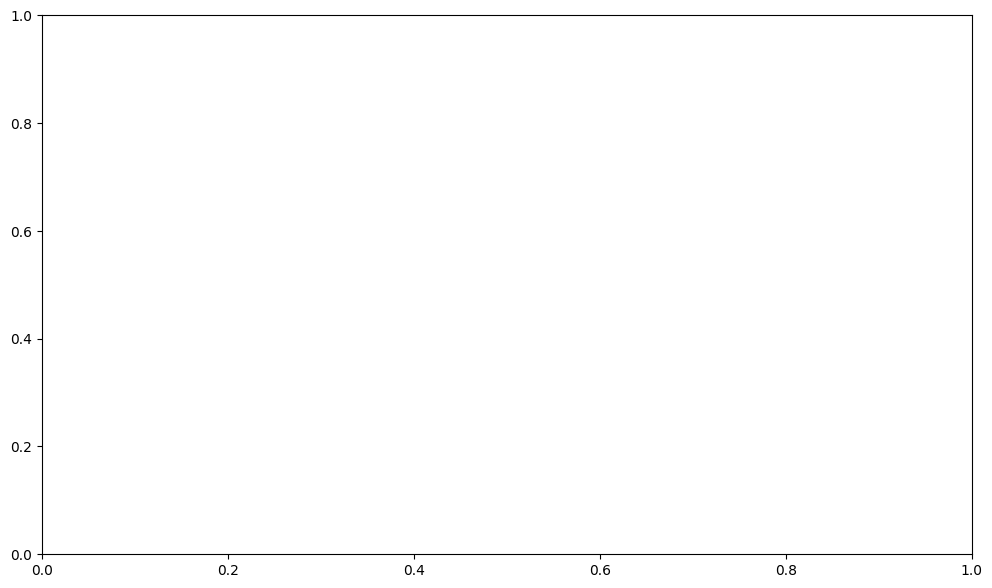

In [7]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Function to generate a color map for keystep IDs with distinct colors
def get_unique_colors(num_colors):
    return cm.get_cmap('tab20', num_colors)  # Using 'hsv' for distinct colors

# Function to plot keystep sequences using horizontal bar plot
def plot_keystep_bars(ground_truth, predicted, subject, trial, keystep_dict, plots_dir):
    # Get unique keystep IDs for ground truth and predicted keysteps
    all_keysteps = list(set(ground_truth['keystep_id'].unique()).union(set(predicted['pred_keystep_id'].unique())))
    
    # Generate a color map with as many unique colors as there are keysteps
    color_map = get_unique_colors(len(all_keysteps))
    color_dict = {keystep_id: color_map(i) for i, keystep_id in enumerate(all_keysteps)}

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 7))  # Increased height for better spacing

    # Plot horizontal bars for ground truth keysteps
    y_pos_gt = 0  # Position for ground truth timeline
    for i, (start, end, keystep_id) in enumerate(zip(ground_truth['start_frame'], ground_truth['end_frame'], ground_truth['keystep_id'])):
        width = max(end - start, 5)  # Ensure a minimum width of 5 for visibility
        ax.barh(y_pos_gt, width, left=start, height=0.6, color=color_dict[keystep_id], edgecolor='black',  linewidth=0.25)
        y_pos_gt += 1  # Move to next row for ground truth

    # Plot horizontal bars for predicted keysteps
    y_pos_pred = y_pos_gt + 1  # Leave a gap between ground truth and predicted
    for i, (start, end, pred_keystep_id) in enumerate(zip(predicted['start_frame'], predicted['end_frame'], predicted['pred_keystep_id'])):
        width = max(end - start, 5)  # Ensure a minimum width of 5 for visibility
        if pred_keystep_id != ground_truth['keystep_id'].iloc[i]:
            ax.barh(y_pos_pred, width, left=start, height=0.6, color=color_dict[pred_keystep_id], edgecolor='black', linewidth=2, hatch='//')  # Highlight mismatches
            # ax.barh(y_pos_pred, width, left=start, height=0.6, color=color_dict[pred_keystep_id], edgecolor='black', linewidth=2)  # Highlight mismatches

        else:
            ax.barh(y_pos_pred, width, left=start, height=0.6, color=color_dict[pred_keystep_id], edgecolor='black', linewidth=0.25)
        y_pos_pred += 1  # Move to next row for predicted

    # Create a horizontal legend at the bottom
    legend_elements = [plt.Line2D([0], [0], color=color_dict[k], lw=4, label=f"{k}: {keystep_dict[k]}") for k in all_keysteps]
    ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=4, title="Keysteps")

    # Add labels for the timelines
    ax.text(-300, y_pos_gt - 7, 'Ground Truth', va='center', fontsize=10, color='blue')
    ax.text(-300, y_pos_pred - 6, 'Prediction', va='center', fontsize=10, color='red')

    # hide top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)


    # Set axis limits and labels
    ax.set_xlim([0, max(ground_truth['end_frame'].max(), predicted['end_frame'].max())])
    ax.set_yticks([])  # Hide y-axis labels
    ax.set_xlabel('Frame Number')
    ax.set_title(f'Keystep Sequences for Subject {subject} Trial {trial}')

    # save figure
    plt.savefig(f'{plots_dir}/subject_{subject}_trial_{trial}_keystep_bars.png', bbox_inches='tight')
    # Show plot
    # plt.tight_layout()
    # plt.show()


df = pd.read_csv(results_csv)

keysteps_dict = args.dataloader_params['keysteps']
print(keysteps_dict)

# Inverting the dictionary to map keystep_id to natural language description
keystep_id_to_desc = {i: v for i, v in enumerate(keysteps_dict.values())}

# Adding a new column to the dataframe that maps keystep_id to the corresponding natural language description
df['keystep_description'] = df['keystep_id'].map(keystep_id_to_desc)
df['pred_keystep_description'] = df['pred_keystep_id'].map(keystep_id_to_desc)

# Display the updated dataframe
df.head()

# get keysteps dict
keysteps_dict = args.dataloader_params['keysteps']
# Inverting the dictionary to map keystep_id to natural language description
keystep_id_to_desc = {i: v for i, v in enumerate(keysteps_dict.values())}

keysteps_dict = keystep_id_to_desc

# Example usage with one subject's trial data
for (subject, trial), group in df.groupby(['subject_id', 'trial_id']):
    ground_truth_data = group[['keystep_id', 'start_frame', 'end_frame']]
    predicted_data = group[['pred_keystep_id', 'start_frame', 'end_frame']]

    plots_dir = f'{results_dir}/plots/bar_plots'
    os.makedirs(plots_dir, exist_ok=True)
    # Plot using the keystep IDs with horizontal bar plot and color legend
    plot_keystep_bars(ground_truth_data, predicted_data, subject, trial, keysteps_dict, plots_dir)
    # break  # Only plot the first subject's trial for now


## Detail result plot


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sample data from the table
data = {
    'Model': ['ICRA Model']*18,
    'Modality': ['Video (Resnet50)']*6 + ['I3D (RGB,Flow)']*6 + ['IMU (Smartwatch)']*6,
    'Window': ['4s']*3 + ['Full']*3 + ['4s']*3 + ['Full']*3 + ['4s']*3 + ['Full']*3,
    'IOU': ['0', '0.25', '0.5']*6,
    'Precision': [0.658, 0.658, 0.567, 0.644, 0.640, 0.625, 
                  0.663, 0.663, 0.636, 0.661, 0.661, 0.651, 
                  0.556, 0.556, 0.528, 0.490, 0.490, 0.457],
    'Recall': [0.701, 0.701, 0.594, 0.683, 0.670, 0.651, 
               0.715, 0.715, 0.674, 0.703, 0.703, 0.687, 
               0.614, 0.614, 0.584, 0.551, 0.551, 0.507],
    'F1-score': [0.659, 0.659, 0.565, 0.641, 0.634, 0.619, 
                 0.672, 0.672, 0.640, 0.662, 0.662, 0.651, 
                 0.571, 0.571, 0.542, 0.500, 0.500, 0.464],
    'Accuracy': [0.700, 0.700, 0.700, 0.680, 0.680, 0.680,
                 0.711, 0.711, 0.711, 0.701, 0.701, 0.701,
                 0.603, 0.603, 0.603, 0.562, 0.562, 0.562],
    'Edit Score': [0.862, 0.862, 0.862, 0.798, 0.798, 0.798,
                   0.865, 0.865, 0.865, 0.810, 0.810, 0.810,
                   0.839, 0.839, 0.839, 0.753, 0.753, 0.753],
    'Edit Distance': [4.909, 4.909, 4.909, 3.955, 3.955, 3.955,
                      4.909, 4.909, 4.909, 3.682, 3.682, 3.682,
                      5.591, 5.591, 5.591, 4.591, 4.591, 4.591]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Set plot style
sns.set_theme(style="whitegrid", palette=sns.color_palette("hls", 3))


# Plot 1: Precision for each modality and window size
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='IOU', y='Precision', hue='Modality', style='Window', markers=True, linewidth=1.5, markersize=10)
plt.title('Precision vs IOU')
plt.xlabel('IOU')
plt.ylabel('Precision')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=7)
plt.savefig(f'{results_dir}/plots/precision_vs_iou.png', bbox_inches='tight')
plt.tight_layout()
plt.show()

# Plot 2: Recall for each modality and window size
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='IOU', y='Recall', hue='Modality', style='Window', markers=True)
plt.title('Recall vs IOU')
plt.xlabel('IOU')
plt.ylabel('Recall')
plt.legend( loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=7)
plt.savefig(f'{results_dir}/plots/recall_vs_iou.png', bbox_inches='tight')
plt.tight_layout()
plt.show()

# Plot 3: F1-score for each modality and window size
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='IOU', y='F1-score', hue='Modality', style='Window', markers=True)
plt.title('F1-score vs IOU')
plt.xlabel('IOU')
plt.ylabel('F1-score')
plt.legend( loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=7)
plt.savefig(f'{results_dir}/plots/f1_score_vs_iou.png', bbox_inches='tight')
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sample data from the table
data = {
    'Model': ['ICRA Model']*18,
    'Modality': ['Video (Resnet50)']*6 + ['I3D (RGB,Flow)']*6 + ['IMU (Smartwatch)']*6,
    'Window': ['4s']*3 + ['Full']*3 + ['4s']*3 + ['Full']*3 + ['4s']*3 + ['Full']*3,
    'IOU': ['0', '0.25', '0.5']*6,
    'Precision': [0.658, 0.658, 0.567, 0.644, 0.640, 0.625, 
                  0.663, 0.663, 0.636, 0.661, 0.661, 0.651, 
                  0.556, 0.556, 0.528, 0.490, 0.490, 0.457],
    'Recall': [0.701, 0.701, 0.594, 0.683, 0.670, 0.651, 
               0.715, 0.715, 0.674, 0.703, 0.703, 0.687, 
               0.614, 0.614, 0.584, 0.551, 0.551, 0.507],
    'F1-score': [0.659, 0.659, 0.565, 0.641, 0.634, 0.619, 
                 0.672, 0.672, 0.640, 0.662, 0.662, 0.651, 
                 0.571, 0.571, 0.542, 0.500, 0.500, 0.464],
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Set plot style
sns.set_theme(style="whitegrid", palette=sns.color_palette("hls", 3))

# Create a figure with three subplots horizontally
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot 1: Precision vs IOU
sns.lineplot(data=df, x='IOU', y='Precision', hue='Modality', style='Window', markers=True, linewidth=1.5, markersize=10, ax=axes[0])
axes[0].set_title('Precision vs IOU')
axes[0].set_xlabel('IOU')
axes[0].set_ylabel('Precision')

# Plot 2: Recall vs IOU
sns.lineplot(data=df, x='IOU', y='Recall', hue='Modality', style='Window', markers=True, linewidth=1.5, markersize=10, ax=axes[1])
axes[1].set_title('Recall vs IOU')
axes[1].set_xlabel('IOU')
axes[1].set_ylabel('Recall')

# Plot 3: F1-score vs IOU
sns.lineplot(data=df, x='IOU', y='F1-score', hue='Modality', style='Window', markers=True, linewidth=1.5, markersize=10, ax=axes[2])
axes[2].set_title('F1-score vs IOU')
axes[2].set_xlabel('IOU')
axes[2].set_ylabel('F1-score')

# Remove legends from individual plots
axes[0].legend_.remove()
axes[1].legend_.remove()
axes[2].legend_.remove()

# Create a single legend for the entire figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=8)

plt.savefig(f'{results_dir}/plots/metrics_vs_iou.png', bbox_inches='tight')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the legend
plt.show()



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Flatten the JSON structure into a DataFrame (same as before)
rows = []
for model in data["model"]:
    for exp in model["experiments"]:
        if "iou_results" in exp:
            for iou_result in exp["iou_results"]:
                rows.append({
                    "Model": model["model_name"],
                    "Modality": exp["modality"],
                    "Window": exp["window_size"],
                    "IOU": iou_result["iou"],
                    **iou_result["results"]
                })
        else:
            rows.append({
                "Model": model["model_name"],
                "Modality": exp["modality"],
                "Window": exp["window_size"],
                "IOU": "N/A",
                **exp["results"]
            })

# Convert to DataFrame
df = pd.DataFrame(rows)

# Replace 'N/A' with np.nan
df.replace("N/A", np.nan, inplace=True)

# Now, ensure numeric columns can be properly converted to float
df["IOU"] = pd.to_numeric(df["IOU"], errors='coerce')

# Now you can handle NaN in several ways
# For example, you can drop rows with NaN IOU values or other missing numeric values
df.dropna(subset=['IOU'], inplace=True)

# Set plot style
sns.set_theme(style="whitegrid", palette=sns.color_palette("hls", 3))

# Plot 1: Precision for each modality and window size
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='IOU', y='precision', hue='Modality', style='Window', markers=True, linewidth=1.5, markersize=10)
plt.title('Precision vs IOU')
plt.xlabel('IOU')
plt.ylabel('Precision')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=7)
plt.savefig(f'{results_dir}/precision_vs_iou.png', bbox_inches='tight')
plt.tight_layout()
plt.show()

# Plot 2: Recall for each modality and window size
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='IOU', y='recall', hue='Modality', style='Window', markers=True, linewidth=1.5, markersize=10)
plt.title('Recall vs IOU')
plt.xlabel('IOU')
plt.ylabel('Recall')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=7)
plt.savefig(f'{results_dir}/recall_vs_iou.png', bbox_inches='tight')
plt.tight_layout()
plt.show()

# Plot 3: F1-score for each modality and window size
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='IOU', y='f1', hue='Modality', style='Window', markers=True, linewidth=1.5, markersize=10)
plt.title('F1-score vs IOU')
plt.xlabel('IOU')
plt.ylabel('F1-score')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=7)
plt.savefig(f'{results_dir}/f1_score_vs_iou.png', bbox_inches='tight')
plt.tight_layout()
plt.show()
